# Parameter Estimation

Parameter estimation for ODE models is provided by the JuliaDiffEq suite. The current functionality includes build_loss_objective. Note that these require that the problem be defined using a [ParameterizedFunction](https://github.com/JuliaDiffEq/ParameterizedFunctions.jl):


## Setting up the parameter estimation problem

Let's try parameter estimation for an ODE on the challenging Lorenz attractor. We base our implementation on the code from Paulo Marques available at: https://github.com/pjpmarques/Julia-Modeling-the-World/blob/master/Lorenz%20Attractor.ipynb and on the global optimization method provided by BlackBoxOptim.

The system is formally described by three different differential equations. These equations represent the movement
of a point $(x, y, z)$ in space over time. In the following equations, $t$ represents time, $\sigma$, $\rho$, $\beta$ are constants.

$$ \begin{align}
    \frac{dx}{dt} &= \sigma (y - x) \\
    \frac{dy}{dt} &= x (\rho - z) - y \\
    \frac{dz}{dt} &= x y - bz
\end{align} $$


Or in matrix form:

$$ \begin{pmatrix}
\dot{x} \\
\dot{y} \\
\dot{z}
\end{pmatrix} = 
\begin{pmatrix}
- \sigma & \sigma & 0 \\
r - z & -1 & - x \\
y & x & -b
\end{pmatrix}
\begin{pmatrix}
x \\
y \\
z
\end{pmatrix}$$

True parameters: $\sigma$, $\rho$ and $\beta$ are used to construct the dataset. In the estimation problem of the ODE system, these are unknown and should be estimated.

In [1]:
using DifferentialEquations, RecursiveArrayTools, BlackBoxOptim, Plots, GR

INFO: Precompiling module SteadyStateDiffEq.


In [2]:
g1 = @ode_def_nohes LorenzExample begin
  dx = σ*(y-x)
  dy = x*(ρ-z) - y
  dz = x*y - β*z
end σ=>10.0 ρ=>28.0 β=>2.6666 # Parameters used to construct the dataset

r0 = [0.1; 0.0; 0.0] # Initial values of the system in space
tspan = (0.0, 4.0)
prob = ODEProblem(g1, r0, tspan)
tspan2 = (0.0, 3.0)
prob_short = ODEProblem(g1, r0, tspan2)

DiffEqBase.ODEProblem{Array{Float64,1},Float64,true,LorenzExample,Void,UniformScaling{Int64}}(LorenzExample,[0.1,0.0,0.0],(0.0,3.0),nothing,UniformScaling{Int64}
1*I)

The second phase of parameter estimation consists in forming the dataset by integrating the dynamic system over a time/space interval. 

Define the time vector and the interval grid

In [3]:
dt = 0.001
tf = 4.0
tinterval = 0:dt:tf
t  = collect(tinterval)

4001-element Array{Float64,1}:
 0.0  
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009
 0.01 
 0.011
 0.012
 ⋮    
 3.989
 3.99 
 3.991
 3.992
 3.993
 3.994
 3.995
 3.996
 3.997
 3.998
 3.999
 4.0  

But in order to compare to the parameter estimation in the [Xiang2015] paper, we also use their integration interval of 300 observations instead:

In [4]:
h = 0.01
M = 300
tstart = 0.0
tstop = tstart + M * h
tinterval_short = 0:h:tstop
t_short = collect(tinterval_short)

301-element Array{Float64,1}:
 0.0 
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1 
 0.11
 0.12
 ⋮   
 2.89
 2.9 
 2.91
 2.92
 2.93
 2.94
 2.95
 2.96
 2.97
 2.98
 2.99
 3.0 

Integrate the ODE system from a starting point and into the future given a sequence of time steps.

In [5]:
#solve(prob_short,Euler(),tstops=t_short)
sol = solve(prob_short,Vern7(),saveat=t_short,abstol=1e-12,reltol=1e-12)
data_short = vecarr_to_arr(sol)
data_short  .+= 0.1randn(size(data_short)) # adding noise to the data

3×301 Array{Float64,2}:
 0.219786    0.0294109  -0.109138   …   -9.69472   -9.5985   -9.66211
 0.0112789   0.0177511  -0.0564706     -10.1297   -10.1412  -10.043  
 0.0177805  -0.134053   -0.105138       27.5026    27.9855   27.913  


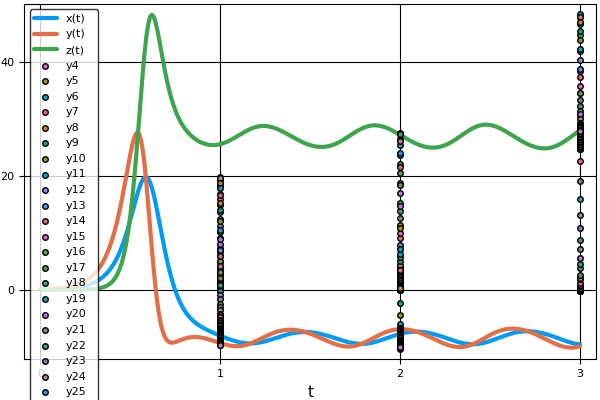

In [6]:
plot!(sol)                           # ,layout=(3,1),size=(800,600))
scatter!(data_short)                 #t,data_short, layout=(3,1),size=(800,600))

Calculate the actual/original state vectors that will be used for parameter estimation:

In [7]:
sol = solve(prob,Vern7(),saveat=t,abstol=1e-12,reltol=1e-12)
data = vecarr_to_arr(sol)
data  .+= 0.1randn(size(data)) # adding noise to the data

3×4001 Array{Float64,2}:
 -0.0134909   0.13573    -0.0236031  …  -7.39841  -7.33984  -7.20717
 -0.118708   -0.0617954   0.0891885     -7.86665  -7.8955   -7.82084
  0.191345   -0.0129725  -0.0511599     24.8139   24.7443   24.829  

The fundamental layout of the data matrix is: equations as rows and sequence of observations as columns:


## Non Linear Programming as an estimation method

The third phase of the parameter estimation problem is to set up the objective function of the NLP problem. The solution below should then be matched with build_loss_objective to simplify and standardize the NLP problem. The aim of build_loss_objective is to make the NLP problem compatible with solvers like Optim.jl and MathProgBase-associated solvers like NLopt.

We have n observations $(\boldsymbol{x}_i, y_i), i = 1,2...,n$, from a fixed-regressor nonlinear model with a known functional relationship $f$. Thus

$$ \begin{align}
        y_i = f(\boldsymbol{x}_i; \boldsymbol{\theta}^*) + \epsilon_i & \quad (i = 1,2,....,n)
\end{align} $$

where $E[\epsilon_i]$ = 0, $\boldsymbol{x}_i$ is a k x 1 vector, and the true value $\boldsymbol{\theta}^*$ of $\boldsymbol{\theta}$ is known to belong to $\boldsymbol{\Theta}$, a subset of $R^p$. The nonlinear least squares estimate of $\boldsymbol{\theta}^*$, denoted by $\boldsymbol{\hat{\theta}}$, minimizes the error sum of squares:

$$ \begin{align}
S(\boldsymbol{\theta}) = \sum_{i=1}^{n} [y_i - f(\boldsymbol{x}_i;\boldsymbol{\theta})]^2 & \quad   \boldsymbol{\theta} \in \boldsymbol{\Theta}.
\end{align} $$

With the notation $f_i(\boldsymbol{\theta})$ = $f(\boldsymbol{x}_i;\boldsymbol{\theta})$ and $\boldsymbol{f}(\boldsymbol{\theta})$ = $\big($$f_1(\boldsymbol{\theta})$, $f_2(\boldsymbol{\theta})$,$\dots$, $f_n(\boldsymbol{\theta})$$\big)$', the error sum of squares, $S(\boldsymbol{\theta})$, can also be re-written as:

$$ \begin{align}
S(\boldsymbol{\theta}) = [y - \boldsymbol{f}(\boldsymbol{\theta})]'[y - \boldsymbol{f}(\boldsymbol{\theta})] = \|y - \boldsymbol{f}(\boldsymbol{\theta}\|^2
\end{align} $$

This quantity, labelled the data misfit function, is a quadratic metric, squared Euclidean distance,  named ESS = Error Sum of Squares, columnwise. This is the $S(\boldsymbol{\theta})$ function 2.2 and 2.7 of Seber and Wild page 21.

In [8]:
# build cost function
function ess2(actual, estimated)
    sumsq = 0.0
    for i in 1:size(actual, 2)
        @inbounds sumsq += sumabs2(actual[i] .- estimated[:, i])
    end
    sumsq
end

ess2 (generic function with 1 method)

In [9]:
my_cost_short(sol) = ess2(sol,data_short)
my_cost(sol) = ess2(sol,data)

my_cost (generic function with 1 method)

A typical problem is to find the value of $\boldsymbol{\theta}$ that minimizes a data misfit/loss function $\boldsymbol{h(\theta)}$ having one of the following forms:

$$ \begin{align}
h(\boldsymbol{\theta}) = \sum_{i=1}^{n} [y_i - f(\boldsymbol{x}_i;\boldsymbol{\theta})]^2 = & \sum_{i=1}^{n} r_i(\boldsymbol{\theta})^2,
\end{align} $$

$$ \begin{align}
h(\boldsymbol{\theta}) = \sum_{i=1}^{n} |y_i - f(\boldsymbol{x}_i;\boldsymbol{\theta})| = & \sum_{i=1}^{n} |r_i(\boldsymbol{\theta})|,
\end{align} $$

$$ \begin{align}
h(\boldsymbol{\theta}) = \sum_{i=1}^{n} \rho(r_i(\boldsymbol{\theta})) & \qquad \text{(robust loss functions)}.
\end{align} $$

These functions are available from two Julia packages: Distances.jl and LossFunctions.jl on Github. The ess function has been specified from first principles to check the accuracy and speed of alternative functions from other packages.

We restrict attention to unconstrained minimization where we wish to minimize $h(\boldsymbol{\theta})$ over $\mathbb{R}^p$. Most estimation methods require a global minimum of $h(\boldsymbol{\theta})$, namely a point $\boldsymbol{\hat{\theta}}$ such that $h(\boldsymbol{\theta}) \geq h(\boldsymbol{\hat{\theta}})$ for all $\boldsymbol{\theta}$ in $\mathbb{R}^p$. Global minimization is possible only for very restrictive clases of functions such as convex functions (Dixon and Szeg$\ddot{o}$ [1978]. Therefore, the properties of the selected data misfit functions should check that they are, first and foremost, convex and subsidiarily smooth and/or continuous. 

### Nonlinear Least Squares estimation (nls)

A family of NLS estimators covers several cases of generalized or weighted least squares estimators. The main steps leading to the computation of $\boldsymbol{\hat{\theta}}_G$, the value of $\boldsymbol{\theta}$ minimizing:

$$ \begin{align}
S(\boldsymbol{\theta}) = [y - \boldsymbol{f}(\boldsymbol{\theta})]'\boldsymbol{V^{-1}}[y - \boldsymbol{f}(\boldsymbol{\theta})],
\end{align} $$

$\boldsymbol{V}$ is a known positive definite matrix, $\boldsymbol{J}$ is the Jacobian of $\boldsymbol{f}(\boldsymbol{\theta})$ and $\mathscr{\hat{D}}[\boldsymbol{\hat{\theta}}_G] = \hat{\sigma}^2(\boldsymbol{\hat{J}}'\boldsymbol{V}^{-1}\boldsymbol{\hat{J}})^{-1}$           , an estimate of the asymptotic covariance matrix of $\boldsymbol{\hat{\theta}}_G$:
1. Perform a Cholesky decomposition of $\boldsymbol{V} = \boldsymbol{U}'\boldsymbol{U}$ of $\boldsymbol{V}$
2. Solve $U'z = y$ and $U'k(\boldsymbol{\theta})$ for $\boldsymbol{z}$ and $\boldsymbol{k}$
3. Apply an ordinary nonlinear least-squares technique to

$$ \begin{align}
[z - \boldsymbol{k}(\boldsymbol{\theta})]'[z - \boldsymbol{k}(\boldsymbol{\theta})],
\end{align} $$

Here we illustrate the simplest case when $V = I_n$ and the above steps collapse to an OLS.

### Maximum-likelihood estimation (mle)

As in the NLS case, the family of likelihood estimators covers several cases: maximum likelihood estimator, concentrated likelihood estimator and quasi-likelihood estimator.

If the joint distribution of the $\epsilon_i$ in the above model is assumed to be a known variable instead of a constant, then the maximum-likelihood estimate of $\boldsymbol{\theta}$ is obtained by maximizing the likelihood function. For $\epsilon_i$ i.i.d $N(0, \sigma^2)$ and ignoring some constants then the logarithm of the likelihood $L(\boldsymbol{\theta}, \sigma^2)$ is:

$$L(\boldsymbol{\theta}, \sigma^2) = - \frac{n}{2} ln  \sigma^2 - \frac{1}{2\sigma^2}S(\boldsymbol{\theta})$$

This function is maximized with respect to $\boldsymbol{\theta}$ when $S(\boldsymbol{\theta})$ is minimized when $\boldsymbol{\theta} = \boldsymbol{\hat{\theta}}$, the least squares estimate.

By analogy to the family of least squares estimators above, it is envisaged that this family of likelihood estimators should be coded as follows: 

For the additional cases: the concentrated likelihood and the quasi-likelihood estimators. Each case depends on the properties of the covariance matrix of experimental noise.

The concentrated likelihood method is a two-step method where the first step is the simple likelihood method explained above. It is documented on page 36 of Seber and Wild.

The quasi-likelihood method is a further refinement by relaxing the underlying assumptions of MLE. It is documented on page 43 of Seber and Wild. 

## Global optimization using BlackBoxOptim

The parameter estimation of the Lorenz atractor has proved inaccurate with the family of algorithms available in NLopt. Instead, we are attempting the estimation of these parameters within the class of Differential Evolution (DE) algorithm available with BlackBoxOptim (https://github.com/robertfeldt/BlackBoxOptim.jl). BlackBoxOptim does not yet comply with MathProgBase syntax and the optimization has been set up by Robert Feldt below. It will become MathProgBase compliant in the near future.

To demonstrate the estimation capabilities of BlackBoxOptim, let's sample a small subset first and set the estimation bounds of the parameters as in the [Xiang2015] paper, https://www.hindawi.com/journals/ddns/2015/740721/:

In [10]:
Xiang2015Bounds = Tuple{Float64, Float64}[(9, 11), (20, 30), (2, 3)]

3-element Array{Tuple{Float64,Float64},1}:
 (9.0,11.0) 
 (20.0,30.0)
 (2.0,3.0)  

In [11]:
#obj_short = build_loss_objective(prob_short,Euler(),my_cost_short,tstops=t_short,dense=false,abstol=1e-9,reltol=1e-9) # Fails
obj_short = build_loss_objective(prob_short,Tsit5(),my_cost_short,saveat=t_short,dense=false,abstol=1e-9,reltol=1e-9)
res1 = bboptimize(obj_short;SearchRange = Xiang2015Bounds, MaxSteps = 11e3)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 339 evals, 256 steps, improv/step: 0.438 (last = 0.4375), fitness=80.922267130
1.00 secs, 927 evals, 829 steps, improv/step: 0.341 (last = 0.2984), fitness=17.941716909
1.50 secs, 1613 evals, 1514 steps, improv/step: 0.318 (last = 0.2891), fitness=8.611641877
2.00 secs, 2216 evals, 2117 steps, improv/step: 0.299 (last = 0.2537), fitness=8.455505201
2.51 secs, 2761 evals, 2662 steps, improv/step: 0.294 (last = 0.2734), fitness=8.453701856
3.01 secs, 3314 evals, 3216 steps, improv/step: 0.292 (last = 0.2834), fitness=8.452318966
3.51 secs, 3908 evals, 3810 steps, improv/step: 0.289 (last = 0.2710), fitness=8.452268554
4.01 secs, 4583 evals, 4485 steps, improv/step: 0.291 (last = 0.3037), fitness=8.452266872
4.51 s

BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited","Max number of steps (11000) reached",11001,1.494076275245e9,8.871000051498413,BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(Pair{Symbol,Any}(:SearchRange,Tuple{Float64,Float64}[(9.0,11.0),(20.0,30.0),(2.0,3.0)]),Pair{Symbol,Any}(:MaxSteps,11000),Pair{Symbol,Any}(:RngSeed,80408)),Dict{Symbol,Any}()],Dict{Symbol,Any}(Pair{Symbol,Any}(:MaxStepsWithoutProgress,10000),Pair{Symbol,Any}(:FitnessTolerance,1.0e-8),Pair{Symbol,Any}(:TraceInterval,0.5),Pair{Symbol,Any}(:MinDeltaFitnessTolerance,1.0e-50),Pair{Symbol,Any}(:MaxFuncEvals,0),Pair{Symbol,Any}(:NumRepetitions,1),Pair{Symbol,Any}(:MaxTime,0.0),Pair{Symbol,Any}(:MaxSteps,10000),Pair{Symbol,Any}(:MaxNumStepsWithoutFuncEvals,100),Pair{Symbol,Any}(:RandomizeRngSeed,true)…)],11099,BlackBoxOptim.ScalarFitnessScheme{true}(),BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(8.452266832775065,[10.0038,27.9968,2.66628]),B

In [12]:
obj = build_loss_objective(prob,Tsit5(),my_cost,saveat=t,dense=false,abstol=1e-9,reltol=1e-9)
res2 = bboptimize(obj;SearchRange = Xiang2015Bounds, MaxSteps = 8e3)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.51 secs, 147 evals, 91 steps, improv/step: 0.484 (last = 0.4835), fitness=6407.580552136
1.01 secs, 299 evals, 214 steps, improv/step: 0.435 (last = 0.3984), fitness=215.643291926
1.51 secs, 449 evals, 355 steps, improv/step: 0.380 (last = 0.2979), fitness=215.643291926
2.01 secs, 599 evals, 505 steps, improv/step: 0.376 (last = 0.3667), fitness=215.643291926
2.51 secs, 750 evals, 656 steps, improv/step: 0.360 (last = 0.3046), fitness=215.643291926
3.02 secs, 903 evals, 810 steps, improv/step: 0.342 (last = 0.2662), fitness=138.698245855
3.52 secs, 1054 evals, 961 steps, improv/step: 0.329 (last = 0.2583), fitness=138.698245855
4.02 secs, 1204 evals, 1111 steps, improv/step: 0.323 (last = 0.2867), fitness=133.686001010
4

BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited","Max number of steps (8000) reached",8001,1.494076289824e9,28.063000202178955,BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(Pair{Symbol,Any}(:SearchRange,Tuple{Float64,Float64}[(9.0,11.0),(20.0,30.0),(2.0,3.0)]),Pair{Symbol,Any}(:MaxSteps,8000),Pair{Symbol,Any}(:RngSeed,602038)),Dict{Symbol,Any}()],Dict{Symbol,Any}(Pair{Symbol,Any}(:MaxStepsWithoutProgress,10000),Pair{Symbol,Any}(:FitnessTolerance,1.0e-8),Pair{Symbol,Any}(:TraceInterval,0.5),Pair{Symbol,Any}(:MinDeltaFitnessTolerance,1.0e-50),Pair{Symbol,Any}(:MaxFuncEvals,0),Pair{Symbol,Any}(:NumRepetitions,1),Pair{Symbol,Any}(:MaxTime,0.0),Pair{Symbol,Any}(:MaxSteps,10000),Pair{Symbol,Any}(:MaxNumStepsWithoutFuncEvals,100),Pair{Symbol,Any}(:RandomizeRngSeed,true)…)],8089,BlackBoxOptim.ScalarFitnessScheme{true}(),BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(120.04381943788277,[10.0025,27.9996,2.66653]),Bl

But let's also try relaxing the tight bounds inthe Xiang2015 paper.

In [13]:
LooserBounds = Tuple{Float64, Float64}[(0, 22), (0, 60), (1, 6)]

3-element Array{Tuple{Float64,Float64},1}:
 (0.0,22.0)
 (0.0,60.0)
 (1.0,6.0) 

In [14]:
res3 = bboptimize(obj_short;SearchRange = LooserBounds, MaxSteps = 11e3)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 585 evals, 485 steps, improv/step: 0.348 (last = 0.3485), fitness=2771.854843300
1.00 secs, 1191 evals, 1086 steps, improv/step: 0.312 (last = 0.2829), fitness=150.845572472
1.50 secs, 1836 evals, 1731 steps, improv/step: 0.289 (last = 0.2496), fitness=13.752038844
2.00 secs, 2468 evals, 2363 steps, improv/step: 0.292 (last = 0.3022), fitness=8.721351805
2.51 secs, 3087 evals, 2982 steps, improv/step: 0.290 (last = 0.2827), fitness=8.468476999
3.01 secs, 3716 evals, 3612 steps, improv/step: 0.288 (last = 0.2794), fitness=8.455061246
3.51 secs, 4356 evals, 4252 steps, improv/step: 0.287 (last = 0.2766), fitness=8.452384131
4.01 secs, 5008 evals, 4904 steps, improv/step: 0.282 (last = 0.2485), fitness=8.452284910


BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited","Max number of steps (11000) reached",11001,1.494076327883e9,8.521000146865845,BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(Pair{Symbol,Any}(:SearchRange,Tuple{Float64,Float64}[(0.0,22.0),(0.0,60.0),(1.0,6.0)]),Pair{Symbol,Any}(:MaxSteps,11000),Pair{Symbol,Any}(:RngSeed,553517)),Dict{Symbol,Any}()],Dict{Symbol,Any}(Pair{Symbol,Any}(:MaxStepsWithoutProgress,10000),Pair{Symbol,Any}(:FitnessTolerance,1.0e-8),Pair{Symbol,Any}(:TraceInterval,0.5),Pair{Symbol,Any}(:MinDeltaFitnessTolerance,1.0e-50),Pair{Symbol,Any}(:MaxFuncEvals,0),Pair{Symbol,Any}(:NumRepetitions,1),Pair{Symbol,Any}(:MaxTime,0.0),Pair{Symbol,Any}(:MaxSteps,10000),Pair{Symbol,Any}(:MaxNumStepsWithoutFuncEvals,100),Pair{Symbol,Any}(:RandomizeRngSeed,true)…)],11103,BlackBoxOptim.ScalarFitnessScheme{true}(),BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(8.452266832775106,[10.0038,27.9968,2.66628]),B

In [15]:
println("Results from the short data sequence, 300 observations, used in [Xiang2015] paper:")
estfitness = obj_short(best_candidate(res1), my_cost_short, t_short)
@show (estfitness, best_candidate(res1), best_fitness(res1))
datafitness = obj_short(true_params, my_cost_short, t_short)
@show (datafitness, true_params)

Results from the short data sequence, 300 observations, used in [Xiang2015] paper:


LoadError: MethodError: no method matching (::DiffEqParamEstim.DiffEqObjective{DiffEqParamEstim.##6#10{Bool,Int64,DiffEqBase.#problem_new_parameters,Array{Any,1},DiffEqBase.ODEProblem{Array{Float64,1},Float64,true,LorenzExample,Void,UniformScaling{Int64}},OrdinaryDiffEq.Tsit5,#my_cost_short},DiffEqParamEstim.##9#13})(::Array{Float64,1}, ::#my_cost_short, ::Array{Float64,1})[0m
Closest candidates are:
  DiffEqObjective(::Any, ::Any) at C:\Users\Denis\.julia\v0.5\DiffEqParamEstim\src\build_loss_objective.jl:9
  DiffEqObjective(::Any) at C:\Users\Denis\.julia\v0.5\DiffEqParamEstim\src\build_loss_objective.jl:8[0m

In [16]:
println("Results from the long data sequence, 4000 observations, from Paulo Marques:")
estfitness = nls_estimation(best_candidate(res2), datastates, t)
@show (estfitness, best_candidate(res2), best_fitness(res2))
datafitness = nls_estimation(true_params, datastates, t)
@show (datafitness, true_params)

Results from the long data sequence, 4000 observations, from Paulo Marques:


LoadError: UndefVarError: nls_estimation not defined

In [17]:
println("Results from the short data sequence used in [Xiang2015] paper, but with initial looser bounds:")
estfitness = nls_estimation(best_candidate(res3), datastates_short, t_short)
@show (estfitness, best_candidate(res3), best_fitness(res3))
datafitness = nls_estimation(true_params, datastates_short, t_short)
@show (datafitness, true_params)

Results from the short data sequence used in [Xiang2015] paper, but with initial looser bounds:


LoadError: UndefVarError: nls_estimation not defined